# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/supervised_classification.ipynb)


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kshitijrajsharma/nickyspatial/master?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fexamples%2Fsupervised_classification.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
! pip install nickyspatial

## Summary

In this notebook we will perform following steps
- Load a sample raster image.
- Perform segmentation on the raster.
- Add NDVI feature.
- Define classes and sample collection
- Apply supervised classification using Random Forest Classifier
- Explore additional funtions: Merge_regions, Enclosed_by, Touched_by

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd

from nickyspatial import (
    LayerManager,
    SlicSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_sample,
    plot_layer,
    plot_layer_interactive,
    read_raster,
    plot_layer_interactive_plotly,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassifier,
    Layer  
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "sample.tif")


if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Downloaded sample raster to data\sample.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [2]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (4, 877, 1164)
Coordinate system: PROJCS["WGS 84 / UTM zone 54N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",141],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [5]:
manager = LayerManager()

segmenter = SlicSegmentation(scale=35, compactness=0.80)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 833
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 823)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

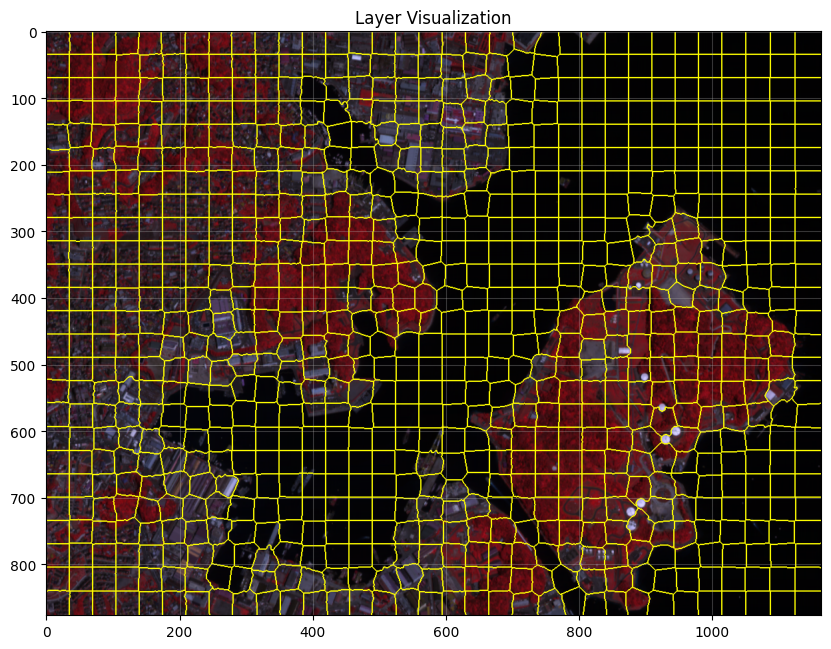

In [6]:
# plt.close("all")
# %matplotlib inline
fig1 = plot_layer(layer=segmentation_layer,
                  image_data=image_data,
                  rgb_bands=(3, 2, 1),
                  show_boundaries=True,
                  figsize=(10,8))
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

## Adding NDVI feature

In [8]:
## Attach NDVI stats at each segmented object
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)

## Attach metrics for the objects generated by the segmentation
segmentation_layer.attach_function(attach_shape_metrics,
                                   name="shape_metrics")

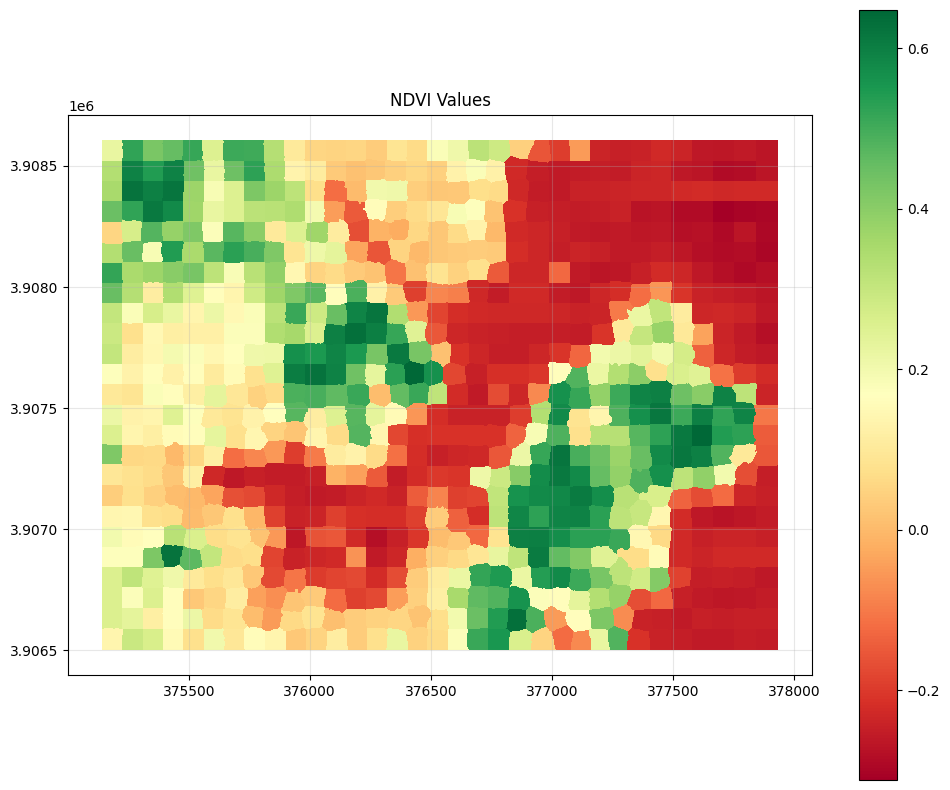

In [9]:
fig2 = plot_layer(segmentation_layer,
                  attribute="NDVI",
                  title="NDVI Values",
                  cmap="RdYlGn")
plt.show()

## Sample data collection

Using plotly package, interactive map is plotted to collect the segments_id(sample) for supervised classification.

Just Hover the mouse in the map, segment_id will be displayed.



In [26]:
plot_layer_interactive_plotly(segmentation_layer,
                              image_data,
                              rgb_bands=(3,2,1),
                              show_boundaries=True,
                              figsize=(900,600))

In [29]:
# Sample Data for Classification
# This section defines the sample data used for classification. 
# Each class is assigned with a list of segment IDs and a specific color for visualization.
samples={
    "Water": [583,217,611,191,579,234,722],
    "Builtup": [751,595,313,239,578],
    "Vegetation": [649,44,587,446,539],
}

classes_color= {
    "Water": "#3437c2",
    "Builtup":"#de1421",
    "Vegetation": "#0f6b2f"
}



## Sample Data Visualization

In this steps, defined sample segment is visualized.

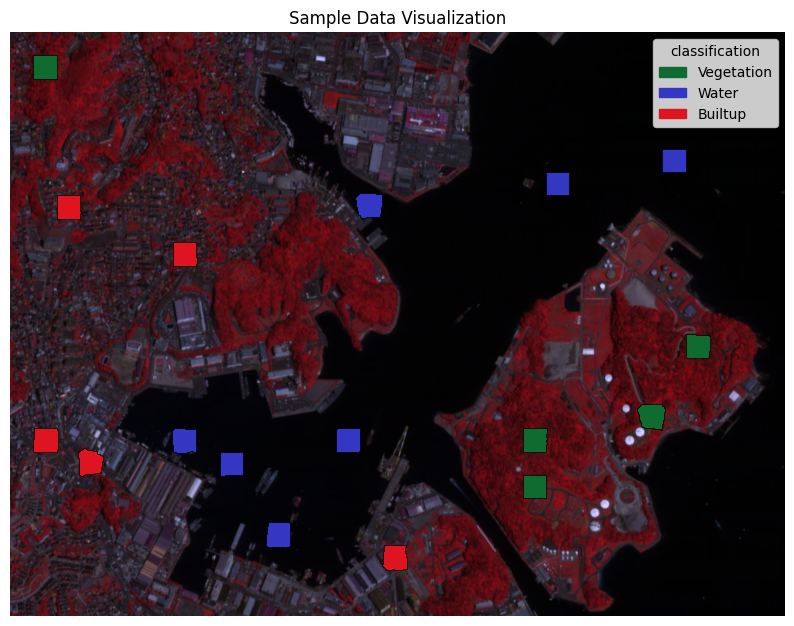

In [30]:
sample_objects = segmentation_layer.objects.copy()
sample_objects["classification"] = None

for class_name in samples.keys():
    sample_objects.loc[sample_objects["segment_id"].isin(samples[class_name]), "classification"] = class_name

# Step 3: Wrap the modified GeoDataFrame back into a Layer
sample_layer = Layer(name="Sample Classification", type="classification")
sample_layer.objects = sample_objects

fig = plot_sample(
    sample_layer,
    image_data=image_data,          
    rgb_bands=(3,2,1),
    transform=transform,          
    class_field="classification",
    class_color=classes_color,
    figsize=(10,8)

)
plt.show()

In [31]:
# To get the columns/features name if the segmentation layer. 
# This is useful to define the features list in the following supervised classification task
segmentation_layer.objects.columns

Index(['segment_id', 'area_pixels', 'area_units', 'geometry', 'band_1_mean',
       'band_1_std', 'band_1_min', 'band_1_max', 'band_1_median',
       'band_2_mean', 'band_2_std', 'band_2_min', 'band_2_max',
       'band_2_median', 'band_3_mean', 'band_3_std', 'band_3_min',
       'band_3_max', 'band_3_median', 'band_4_mean', 'band_4_std',
       'band_4_min', 'band_4_max', 'band_4_median', 'NDVI', 'perimeter',
       'shape_index', 'compactness'],
      dtype='object')

## Supervised Classification using Random Forest Classifier

In this step, we will define and execute the supervised classification.

OOB SCORE 1.0


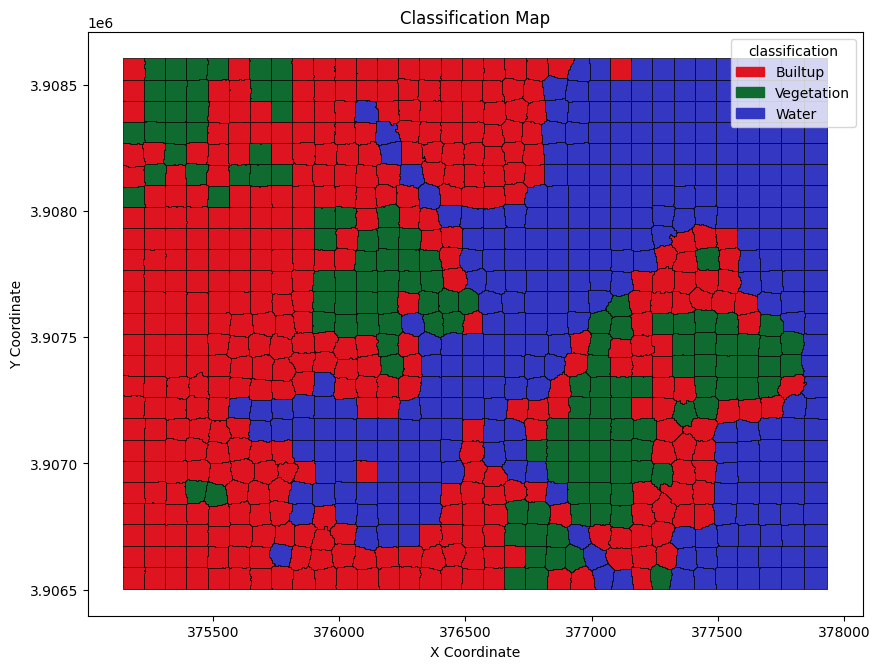

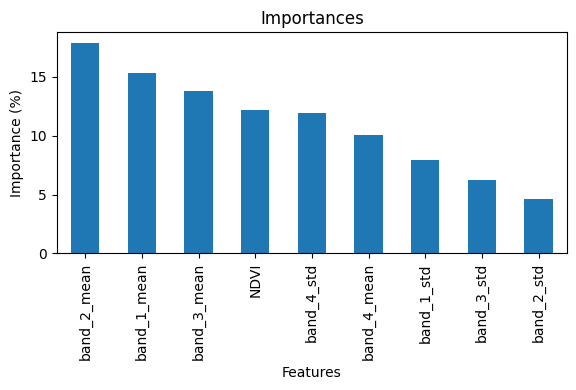

In [32]:
# Parameters for defining Random Forest Classifier
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params={"n_estimators":100, 
        "oob_score":True, 
        "random_state":42,
        }
# Define features based on which classifier performs the classification
features=['band_1_mean','band_1_std', 'band_2_mean', 'band_2_std', 'band_3_mean', 'band_3_std',  'band_4_mean', 'band_4_std','NDVI']

# Define supervised classifier and execute it
RF_classification=SupervisedClassifier(name="RF Classification", classifier_type="Random Forest", classifier_params=params)
RF_classification_layer, accuracy, feature_importances = RF_classification.execute(segmentation_layer,
                                                                                   samples=samples,
                                                                                   layer_manager=manager,
                                                                                   layer_name="RF Classification",
                                                                                   features=features)
print("OOB SCORE",accuracy)

# Plot classification result
fig4 = plot_classification(RF_classification_layer, class_field="classification", class_color=classes_color,figsize=(10,8))

# Plot feature importance graph
ig, ax = plt.subplots(figsize=(6, 4))
feature_importances.plot.bar(ax=ax)
ax.set_title("Importances")
ax.set_xlabel("Features")
ax.set_ylabel("Importance (%)")
plt.tight_layout()
plt.show()


## Applying merge rule
In this step we will further refine the classification. 
In this example, we will merge region based on class value i.e. merge adjacent segments if they share the same class label.

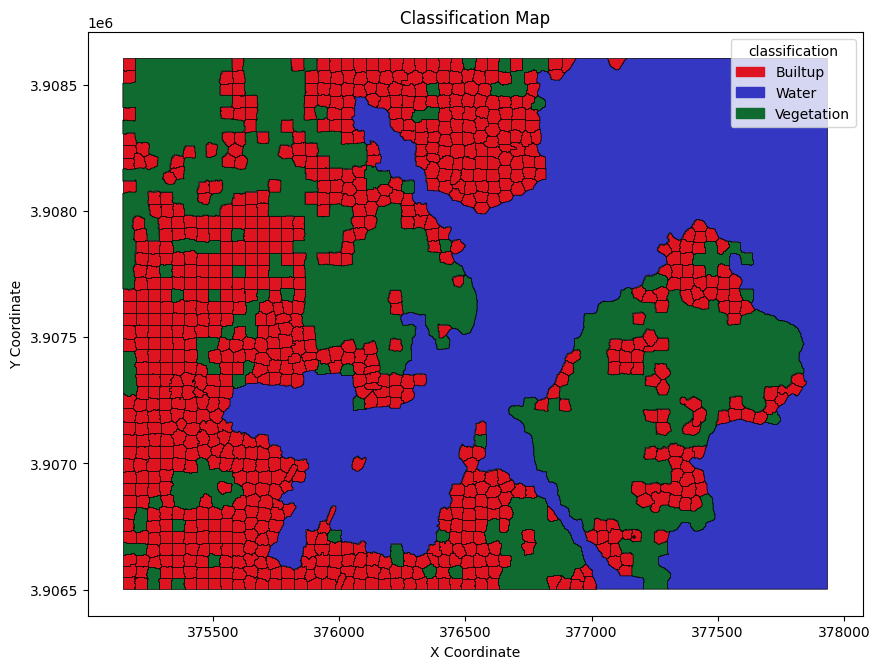

In [12]:
merger = MergeRuleSet("Merge Segmentation")
class_value=["Water","Vegetation"]
merged_layer = merger.execute(
    source_layer=RF_classification_layer,
    class_column_name="classification",
    class_value=class_value,
    layer_manager=manager,
    layer_name="Merged RF Classification",
)
fig4 = plot_classification(merged_layer, class_field="classification", class_color=classes_color,figsize=(10,8))


## Applying Enclosed_by rule
This rule is also applied based on class label. This function determine whether a object/segment is completely contained/surrounded within/by another object or class and return the updated layer.

This function is very helpful in applying the context-aware rules in classification.

In this example, we define the new class "Urban Vegetation" if "Vegetation" is enclosed by "Builtup".


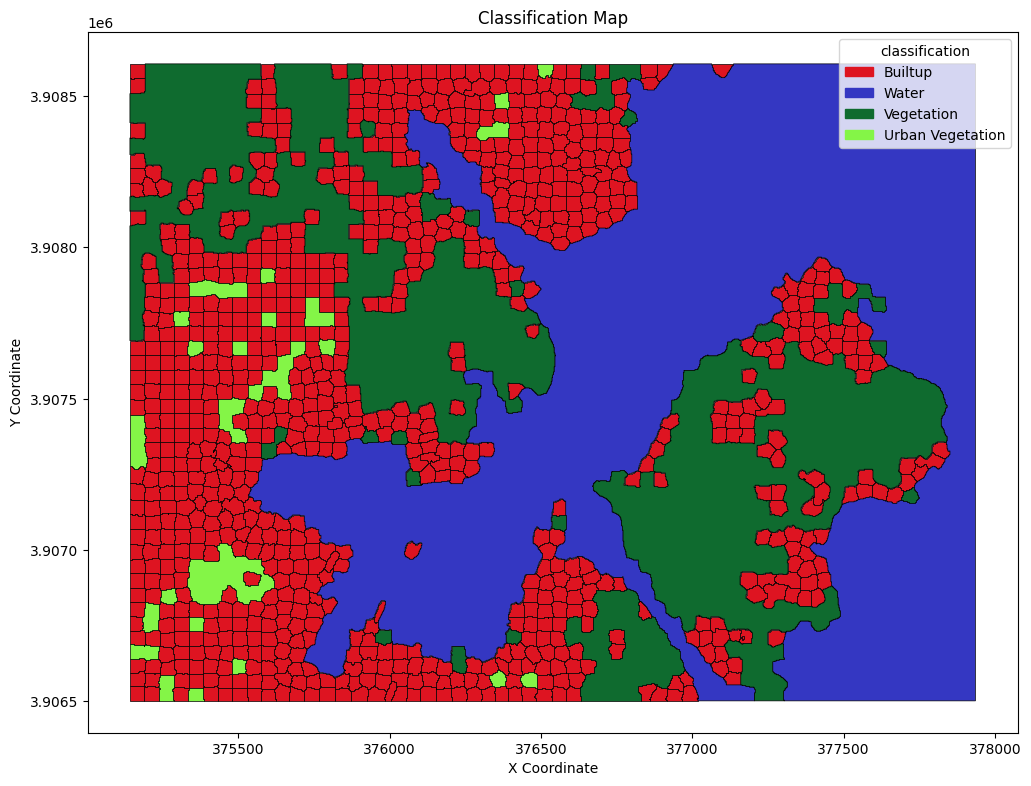

In [13]:
enclosed_by_rule = EnclosedByRuleSet()
enclosed_by_layer = enclosed_by_rule.execute(
    source_layer=merged_layer,
    class_column_name="classification",
    class_value_a="Vegetation",
    class_value_b="Builtup",
    new_class_name="Urban Vegetation",
    layer_manager=manager,
    layer_name="enclosed_by_layer",
)
classes_color["Urban Vegetation"]="#84f547"
fig4 = plot_classification(enclosed_by_layer, class_field="classification", class_color=classes_color)

## Applying Touched_by rule
This rule is also applied based on class labels. This determines whether an object/segment is in direct contact with another object or class — that is, they share a boundary.

This function is very useful in implementing context-aware rules in classification, especially when spatial relationships between features matter.

In this example, we define a new class "Builtup near WaterBodies" if "Builtup" is touchedBy "Water".


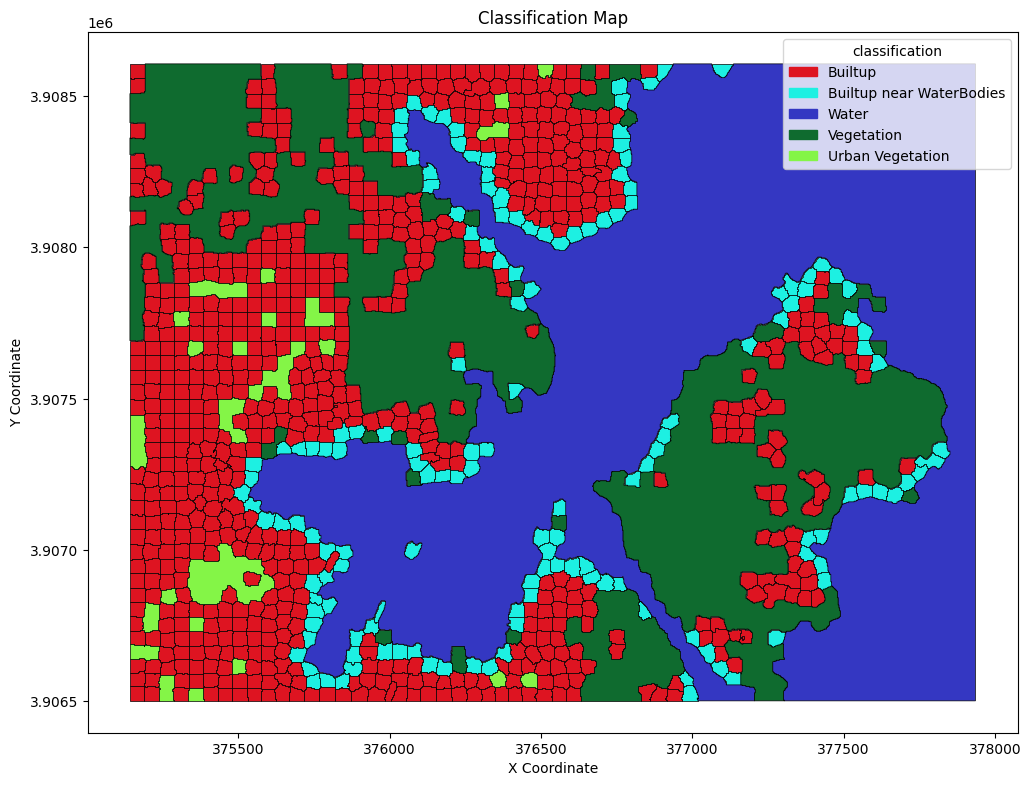

In [14]:
touched_by_rule = TouchedByRuleSet()
touched_by_layer = touched_by_rule.execute(
    source_layer=enclosed_by_layer,
    class_column_name="classification",
    class_value_a="Builtup",
    class_value_b="Water",
    new_class_name="Builtup near WaterBodies",
    layer_manager=manager,
    layer_name="touched_by_layer",
)
classes_color["Builtup near WaterBodies"]="#1df0e2"
fig4 = plot_classification(touched_by_layer, class_field="classification", class_color=classes_color)

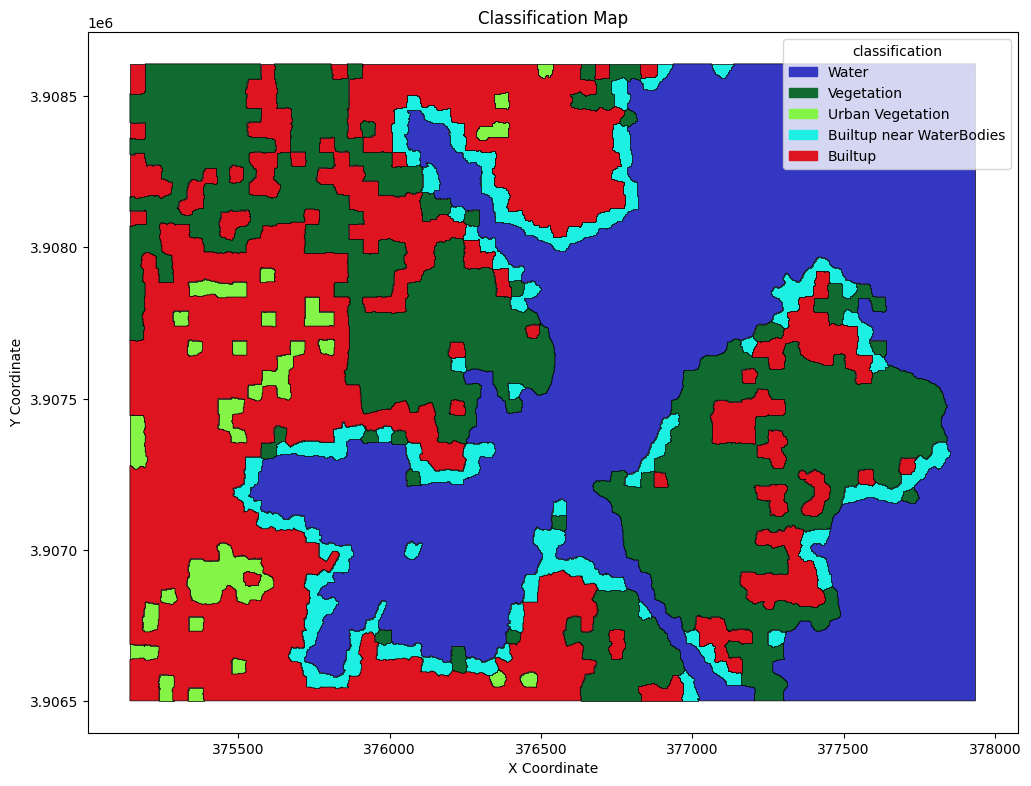

In [ ]:
# Applying merge rule to generate the final merged segments
merge_rule = MergeRuleSet("MergeByVegAndType")
merged_layer2 = merger.execute(
    source_layer=touched_by_layer,
    class_column_name="classification",
    class_value=["Builtup near WaterBodies","Builtup"],
    layer_manager=manager,
    layer_name="Merged RF Classification 2",
)
fig4 = plot_classification(merged_layer2, class_field="classification", class_color=classes_color)